In [1]:
rm -rf sample_data/

In [2]:
pwd

'/content'

#### upload wheat_bangalore.csv to /content folder

In [3]:
ls

Wheat_Bangalore.csv


In [5]:
# import statements
from pandas import DataFrame, read_csv, Series, concat, datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
from math import sqrt
from matplotlib import pyplot as plt
import numpy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  


### Data Preprocessing Functions

In [11]:
# date-time parsing function (dataset dependent)
def dateparser(x):
  return datetime.strptime(x, '%Y-%m-%d')


# convert data to frame problem as supervised learning problem (addding a column of lagged values)
def timeseries_to_supervised(data, lag=1):
  df = DataFrame(data)
  columns = [df.shift(i) for i in range(1, lag+1)]
  columns.append(df)
  df = concat(columns, axis=1)
  df.fillna(0, inplace=True)
  return df

# create a differenced series
def difference(dataset, interval=1):
  diff = list()
  for i in range(interval, len(dataset)):
    value = dataset[i] - dataset[i-interval]
    diff.append(value)
  return Series(diff)


# inverting differenced value
def inverse_difference(history, y_predicted, interval=1):
  return y_predicted + history[-interval]


# scale data (test and train) between 1 and -1
def scale(train, test):
  # fit scaler
  scaler = MinMaxScaler(feature_range=(-1,1))
  scaler = scaler.fit(train)

  # transform train
  train = train.reshape(train.shape[0], train.shape[1])
  train_scaled = scaler.transform(train)

  # transform test
  test = test.reshape(test.shape[0], test.shape[1])
  test_scaled = scaler.transform(test)

  return scaler, train_scaled, test_scaled


# inverse scaling for a forecasted value
def inverse_scale(scaler, X, value):
  new_row = [x for x in X] + [value]
  array = numpy.array(new_row)
  array = array.reshape(1, len(array))
  inverted = scaler.inverse_transform(array)
  return inverted[0,-1]

#### Fit and Predicted functions

In [12]:
# fit an LSTM network on training data
def fit_lstm(train, batch_size, nb_epochs, neurons):
  X,y = train[:,0:-1], train[:,-1]
  X = X.reshape(X.shape[0], 1, X.shape[1])    #samples, timestamps, features

  # model
  model = Sequential()
  model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]),stateful=True))
  model.add(Dense(1))

  model.compile(loss='mean_squared_error', optimizer='adam')

  for i in range(nb_epochs):
    model.fit(X, y, epochs=1, batch_size=batch_size, shuffle=False)
    model.reset_states()
  return model


# make a one-step forecast
def forecast_lstm(model, batch_size, X):
  X = X.reshape(1,1,len(X))
  y_predicted = model.predict(X, batch_size=batch_size)
  return y_predicted[0,0]

#### MAIN and function calls

In [23]:
# load dataset
series = read_csv('Wheat_Bangalore.csv', usecols=['Date','MeanPrice(Rs./Quintal)'],header=0, index_col=0, parse_dates=[0], date_parser=dateparser, squeeze=True)
series

# transform data to be stationary
raw_values = series.values
diff_values = difference(raw_values,1)

# transform data to be supervised
supervised = timeseries_to_supervised(diff_values,1)
supervised_values = supervised.values

# split data into train and test dataset
train, test = supervised_values[:-8], supervised_values[-8:]

# transform the scale of data
scaler, train_scaled, test_scaled = scale(train, test)


# fit the model
lstm_model = fit_lstm(train_scaled, 1, 50, 4)


# forecast entire dataset to build state for forecasting(?)
train_reshaped = train_scaled[:,0].reshape(len(train_scaled),1,1)
lstm_model.predict(train_reshaped, batch_size=1)


predictions = list()
for i in range(len(test_scaled)):
  # make one-step forecast
  X,y = test_scaled[i,0:-1], test_scaled[i,-1]
  y_predicted = forecast_lstm(lstm_model, 1, X)

  # invert scaling
  y_predicted = inverse_scale(scaler, X, y_predicted)

  # invert differencing
  y_predicted = inverse_difference(raw_values, y_predicted, len(test_scaled)+1-i)

  # store forecast
  predictions.append(y_predicted)
  expected = raw_values[len(train)+i+1]

  print('Prediction=%d, Predicted=%f, Actual=%f'%(i+1, y_predicted, expected))

97/97 [==============================] - 0s 1ms/step - loss: 0.0824
Prediction=1, Predicted=2748.773737, Actual=2750.000000
Prediction=2, Predicted=2781.180969, Actual=2750.000000
Prediction=3, Predicted=2786.583818, Actual=2750.000000
Prediction=4, Predicted=2789.292054, Actual=2900.000000
Prediction=5, Predicted=2892.741393, Actual=2900.000000
Prediction=6, Predicted=2916.477136, Actual=2900.000000
Prediction=7, Predicted=2927.370101, Actual=3014.000000
Prediction=8, Predicted=3009.637066, Actual=2700.000000


In [24]:
# error calculation
rmse = sqrt(mean_squared_error(raw_values[-8:],predictions))
print(f"rmse: {rmse}")

rmse: 121.58968770903982


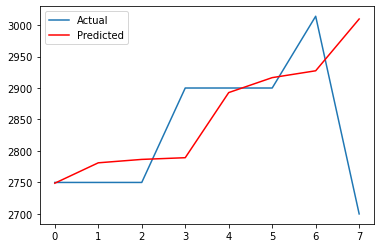

In [25]:
# plot predicted and actual values
plt.plot(raw_values[-8:], label='Actual')
plt.plot(predictions, color='red', label='Predicted')
plt.legend()
plt.show()